In [ ]:
# Install PySpark
!pip install pyspark



In [161]:
# Import SparkSession
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Dataset Preprocessing with PySpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Verify Spark is running
print(f"Spark is running")


Spark is running


**DATA PRE-PROCESSING**

In [143]:
def drop_nulls_rdd(rdd):

#    Removes rows containing null (None) values.

    return rdd.filter(lambda row: None not in row)


In [144]:
def impute_mean_rdd(rdd, col_idx):

  #  Replaces missing (None) values in a column with the mean of that column.

    valid_rows = rdd.filter(lambda row: row[col_idx] is not None)
    values = valid_rows.map(lambda row: row[col_idx])
    if values.isEmpty():  # Check for empty dataset
        raise ValueError(f"Column at index {col_idx} has no valid values for mean calculation.")
    mean_val = values.mean()
    return rdd.map(lambda row: row if row[col_idx] is not None else row[:col_idx] + (mean_val,) + row[col_idx + 1:])


In [145]:
def remove_outliers_rdd(rdd, col_idx, thresh=3):

   # Removes rows with outliers in the specified column based on Z-scores.

    valid_rows = rdd.filter(lambda row: row[col_idx] is not None)
    values = valid_rows.map(lambda row: row[col_idx])
    if values.isEmpty():  # Check for empty dataset
        raise ValueError(f"Column at index {col_idx} has no valid values for outlier detection.")
    mean_val = values.mean()
    std_val = values.stdev()
    if std_val == 0:  # Avoid division by zero
        raise ValueError(f"Column at index {col_idx} has zero standard deviation.")
    return rdd.filter(lambda row: abs((row[col_idx] - mean_val) / std_val) <= thresh)


In [146]:
def bin_data_rdd(rdd, col_idx):

 #   Bins a numerical column into discrete categories (e.g., Low, Medium, High).

    def bin_func(row):
        val = row[col_idx]
        if val < 10:
            category = "Low"
        elif 10 <= val < 50:
            category = "Medium"
        else:
            category = "High"
        return row + (category,)

    return rdd.map(bin_func)


In [147]:
def replace_outliers_rdd(rdd, col_idx, thresh=3):

   # Replaces outliers in a column with the median value.

    values = rdd.filter(lambda row: row[col_idx] is not None).map(lambda row: row[col_idx])
    mean_val = values.mean()
    std_val = values.stdev()
    med_val = values.sortBy(lambda x: x).zipWithIndex().map(lambda x: (x[1], x[0])).lookup(values.count() // 2)[0]
    return rdd.map(lambda row: row if abs((row[col_idx] - mean_val) / std_val) <= thresh else row[:col_idx] + (med_val,) + row[col_idx + 1:])


In [148]:
def add_seq_ids_rdd(rdd):

 #   Adds sequential IDs to each row in the RDD.


    return rdd.zipWithIndex().map(lambda x: (*x[0], x[1]))


In [149]:
def aggregate_window_rdd(rdd, col_idx, agg_func):

    #Applies an aggregation function (e.g., sum, count) to the specified column.

    return rdd.map(lambda row: row[col_idx]).aggregate(0, agg_func, agg_func)


In [150]:
def normalize_rdd(rdd, col_idx):

  #  Normalizes a numerical column to a range [0, 1].

    col_values = rdd.map(lambda row: row[col_idx]).filter(lambda x: x is not None)
    if col_values.isEmpty():
        raise ValueError(f"Column at index {col_idx} has no valid values for normalization.")

    min_val = col_values.min()
    max_val = col_values.max()

    # Handle no variance case
    if min_val == max_val:
        print(f"Column at index {col_idx} has no variance. Skipping normalization.")
        return rdd.map(lambda row: row[:col_idx] + (0.5,) + row[col_idx + 1:])  # Assign a default normalized value (e.g., 0.5)

    return rdd.map(lambda row: row[:col_idx] + ((row[col_idx] - min_val) / (max_val - min_val),) + row[col_idx + 1:])


In [151]:
def sample_data_rdd(rdd, frac):

   # Randomly samples a fraction of the dataset. Reduces data size for testing or exploratory analysis.


    return rdd.sample(False, frac)


In [152]:
def convert_categorical_to_numeric_rdd(rdd, col_idx):
    """
    Converts categorical data in a specific column to numeric using indexing.

    Args:
        rdd (RDD): Input RDD where each row is a tuple.
        col_idx (int): Index of the categorical column to convert.

    Returns:
        RDD: Transformed RDD with the categorical column converted to numeric.
    """
    # Extract unique values and assign numeric indices
    unique_values = rdd.map(lambda row: row[col_idx]).distinct().collect()
    mapping = {val: idx for idx, val in enumerate(unique_values)}

    # Replace categorical values with their numeric indices
    return rdd.map(lambda row: row[:col_idx] + (mapping[row[col_idx]],) + row[col_idx + 1:])

In [156]:
def add_interaction_feature(rdd, col_idx1, col_idx2):

    #Adds an interaction term between two features in the RDD. This makes it simple to access the cols and reduces the calculation time in ML models.

    return rdd.map(lambda row: row + (row[col_idx1] * row[col_idx2],))

In [158]:
def main():
    """
    Main function to execute the PySpark RDD-based data preprocessing pipeline.
    """
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.appName("DistributedDataProcessing").getOrCreate()

    try:
        # Load dataset into RDD
        print("Loading dataset...")
        rdd = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True).rdd
        print("Top 5 rows after loading dataset:")
        print(rdd.take(5))

        # Drop null values
        print("Dropping rows with null values...")
        rdd = drop_nulls_rdd(rdd)
        print("Top 5 rows after dropping null values:")
        print(rdd.take(5))

        # Convert categorical columns to numeric
        print("Converting 'gender' column to numeric...")
        rdd = convert_categorical_to_numeric_rdd(rdd, col_idx=0)  # Assuming 'gender' is at index 0
        print("Top 5 rows after converting 'gender' to numeric:")
        print(rdd.take(5))

        print("Converting 'smoking_history' column to numeric...")
        rdd = convert_categorical_to_numeric_rdd(rdd, col_idx=4)  # Assuming 'smoking_history' is at index 4
        print("Top 5 rows after converting 'smoking_history' to numeric:")
        print(rdd.take(5))

        # Impute missing values with mean
        print("Imputing missing values with mean...")
        rdd = impute_mean_rdd(rdd, col_idx=2)
        print("Top 5 rows after imputing missing values:")
        print(rdd.take(5))

        # Remove outliers using Z-scores
        print("Removing outliers...")
        rdd = remove_outliers_rdd(rdd, col_idx=2)
        print("Top 5 rows after removing outliers:")
        print(rdd.take(5))

        # Bin numerical data into categories
        print("Binning numerical data into categories...")
        rdd = bin_data_rdd(rdd, col_idx=2)
        print("Top 5 rows after binning numerical data:")
        print(rdd.take(5))

        # Replace outliers with median
        print("Replacing outliers with median...")
        rdd = replace_outliers_rdd(rdd, col_idx=2)
        print("Top 5 rows after replacing outliers with median:")
        print(rdd.take(5))

        # Add sequential IDs
        print("Adding sequential IDs to rows...")
        rdd = add_seq_ids_rdd(rdd)
        print("Top 5 rows after adding sequential IDs:")
        print(rdd.take(5))

        # Normalize numerical data
        print("Normalizing numerical data...")
        rdd = normalize_rdd(rdd, col_idx=2)
        print("Top 5 rows after normalizing numerical data:")
        print(rdd.take(5))

        # Sample a fraction of the data
        print("Sampling data (10%)...")
        sampled_rdd = sample_data_rdd(rdd, frac=0.1)
        print("Top 5 rows of sampled data:")
        print(sampled_rdd.take(5))

        # Add interaction feature between "hypertension" and "blood_glucose_level"
        print("Adding interaction feature between hypertension and blood_glucose_level...")
        rdd = add_interaction_feature(rdd, col_idx1=2, col_idx2=3)
        print("Top 5 rows after adding interaction feature:")
        print(rdd.take(5))

        # Collect and display final results
        print("Final processed sample data:")
        print(sampled_rdd.take(5))

    except ValueError as e:
        print(f"Error during preprocessing: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    finally:
        spark.stop()

# Call the main function
if __name__ == "__main__":
    main()


Loading dataset...
Top 5 rows after loading dataset:
[Row(gender='Female', age=80.0, hypertension=0, heart_disease=1, smoking_history='never', bmi=25.19, HbA1c_level=6.6, blood_glucose_level=140, diabetes=0), Row(gender='Female', age=54.0, hypertension=0, heart_disease=0, smoking_history='No Info', bmi=27.32, HbA1c_level=6.6, blood_glucose_level=80, diabetes=0), Row(gender='Male', age=28.0, hypertension=0, heart_disease=0, smoking_history='never', bmi=27.32, HbA1c_level=5.7, blood_glucose_level=158, diabetes=0), Row(gender='Female', age=36.0, hypertension=0, heart_disease=0, smoking_history='current', bmi=23.45, HbA1c_level=5.0, blood_glucose_level=155, diabetes=0), Row(gender='Male', age=76.0, hypertension=1, heart_disease=1, smoking_history='current', bmi=20.14, HbA1c_level=4.8, blood_glucose_level=155, diabetes=0)]
Dropping rows with null values...
Top 5 rows after dropping null values:
[Row(gender='Female', age=80.0, hypertension=0, heart_disease=1, smoking_history='never', bmi=25.

Algorithms/Visualizations [50 marks]: Develop 6 significant machine learning
algorithms (5 for 487 student and 6 for 587 students) using PySpark’s MLib. These
algorithms should be relevant to your domain and specifically trained on large,
distributed datasets. You can use the same models that you used on Phase-2. For 587
students, at least one of these algorithms must be selected from outside the class
materials. Ensure that only PySpark’s MLib is used for model training, taking advantage
of its distributed processing capabilities.

Loading dataset...
Dataset Schema:
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)

Handling null values...
Mapping categorical columns...
Casting columns to DoubleType...
Preparing data...
Training Naive Bayes...
Evaluating Naive Bayes...
Naive Bayes Metrics:
  - Accuracy: 89.84%
  - Precision: 0.89
  - Recall: 0.90
  - F1 Score: 0.89


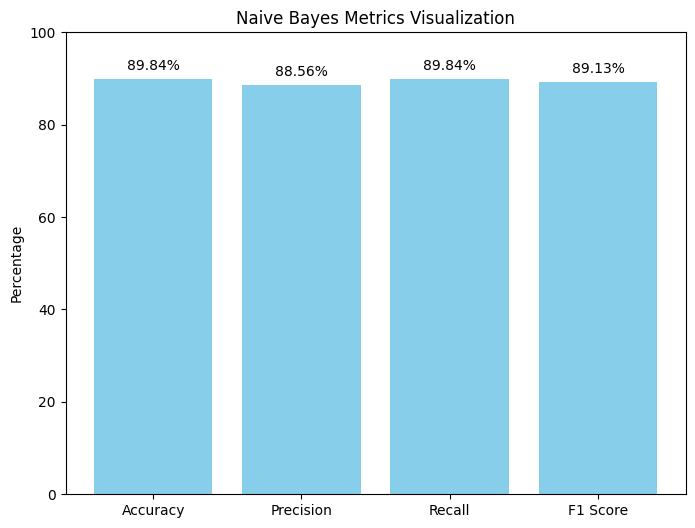

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

# Define preprocessing functions
def cast_to_double(df, columns):
    for column in columns:
        df = df.withColumn(column, col(column).cast("double"))
    return df

def handle_nulls(df, feature_cols, label_col):
    for col_name in feature_cols + [label_col]:
        if str(df.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            mean_value = df.select(mean(col_name)).collect()[0][0]
            df = df.fillna({col_name: mean_value})
        else:
            df = df.fillna({col_name: "Unknown"})
    return df

def map_categorical_columns(df):
    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_indexed").fit(df)
        for col in ["gender", "smoking_history"]
    ]
    for indexer in indexers:
        df = indexer.transform(df)
    return df

def prepare_data(df, label_col, feature_cols):
    indexed_feature_cols = [
        f"{col}_indexed" if col in ["gender", "smoking_history"] else col
        for col in feature_cols
    ]
    assembler = VectorAssembler(inputCols=indexed_feature_cols, outputCol="features", handleInvalid="skip")
    df = assembler.transform(df)
    labeled_rdd = df.select("features", label_col).rdd.map(
        lambda row: LabeledPoint(float(row[label_col]), Vectors.dense(row["features"]))  # Cast to float
    )
    return labeled_rdd

# Initialize SparkSession and prepare data
spark = SparkSession.builder.appName("Naive Bayes Metrics Fix").getOrCreate()
try:
    # Load the dataset
    print("Loading dataset...")
    df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)
    print("Dataset Schema:")
    df.printSchema()

    # Define label and feature columns
    label_col = "diabetes"
    feature_cols = [
        "gender", "age", "hypertension", "heart_disease",
        "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
    ]

    # Preprocess data
    print("Handling null values...")
    df = handle_nulls(df, feature_cols, label_col)
    print("Mapping categorical columns...")
    df = map_categorical_columns(df)
    print("Casting columns to DoubleType...")
    df = cast_to_double(df, feature_cols + [label_col])

    # Prepare data
    print("Preparing data...")
    labeled_rdd = prepare_data(df, label_col, feature_cols)
    train_rdd, test_rdd = labeled_rdd.randomSplit([0.8, 0.2], seed=42)
except Exception as e:
    print(f"Error during preprocessing: {e}")
    spark.stop()

# Define training and evaluation
def train_naive_bayes(train_rdd, test_rdd):
    from pyspark.mllib.classification import NaiveBayes
    model = NaiveBayes.train(train_rdd)
    predictions_rdd = test_rdd.map(lambda p: (float(model.predict(p.features)), float(p.label)))
    return predictions_rdd

def evaluate_metrics(predictions_rdd, model_name="Model"):
    metrics = MulticlassMetrics(predictions_rdd)
    accuracy = predictions_rdd.filter(lambda x: x[0] == x[1]).count() / float(predictions_rdd.count())
    precision = metrics.weightedPrecision
    recall = metrics.weightedRecall
    f1_score = metrics.weightedFMeasure()

    print(f"{model_name} Metrics:")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Precision: {precision:.2f}")
    print(f"  - Recall: {recall:.2f}")
    print(f"  - F1 Score: {f1_score:.2f}")

    return accuracy * 100, precision, recall, f1_score

# Train and evaluate
try:
    print("Training Naive Bayes...")
    predictions = train_naive_bayes(train_rdd, test_rdd)
    print("Evaluating Naive Bayes...")
    accuracy, precision, recall, f1_score = evaluate_metrics(predictions, model_name="Naive Bayes")

    # Visualization
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = [accuracy, precision * 100, recall * 100, f1_score * 100]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_labels, metrics_values, color='skyblue')
    plt.title("Naive Bayes Metrics Visualization")
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    plt.show()

except Exception as e:
    print(f"Error in Naive Bayes training or evaluation: {e}")

finally:
    spark.stop()


Loading dataset...
Dataset Schema:
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)

Handling null values...
Mapping categorical columns...
Casting columns to DoubleType...
Preparing data...
Training Logistic Regression...
Evaluating Logistic Regression...


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression Metrics:
  - Accuracy: 91.39%
  - Precision: 0.88
  - Recall: 0.91
  - F1 Score: 0.88


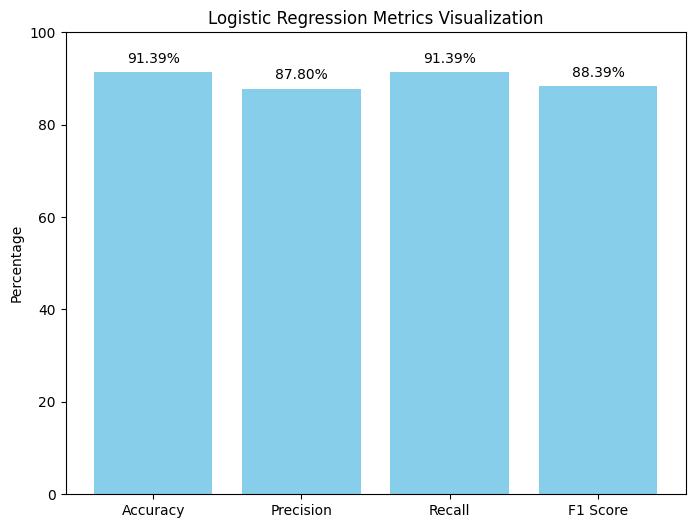

Plotting Confusion Matrix...


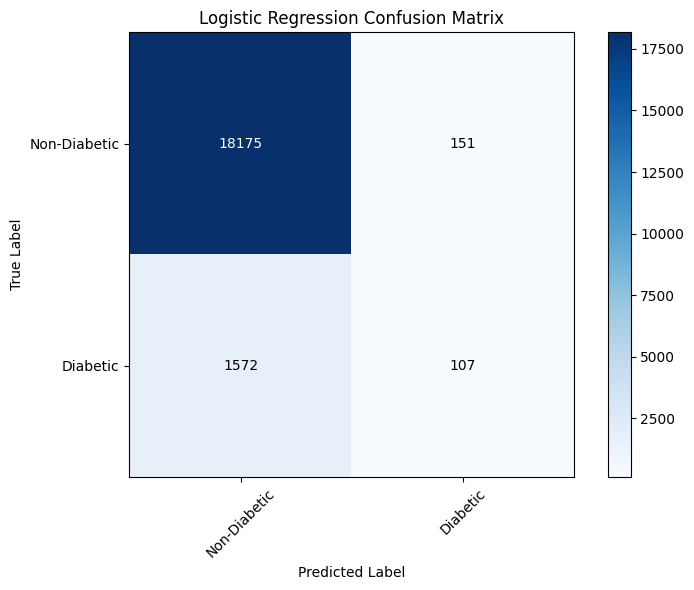

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np

# Define preprocessing functions
def cast_to_double(df, columns):
    for column in columns:
        df = df.withColumn(column, col(column).cast("double"))
    return df

def handle_nulls(df, feature_cols, label_col):
    for col_name in feature_cols + [label_col]:
        if str(df.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            mean_value = df.select(mean(col_name)).collect()[0][0]
            df = df.fillna({col_name: mean_value})
        else:
            df = df.fillna({col_name: "Unknown"})
    return df

def map_categorical_columns(df):
    indexers = [
        StringIndexer(inputCol=col, outputCol=f"{col}_indexed").fit(df)
        for col in ["gender", "smoking_history"]
    ]
    for indexer in indexers:
        df = indexer.transform(df)
    return df

def prepare_data(df, label_col, feature_cols):
    indexed_feature_cols = [
        f"{col}_indexed" if col in ["gender", "smoking_history"] else col
        for col in feature_cols
    ]
    assembler = VectorAssembler(inputCols=indexed_feature_cols, outputCol="features", handleInvalid="skip")
    df = assembler.transform(df)
    labeled_rdd = df.select("features", label_col).rdd.map(
        lambda row: LabeledPoint(float(row[label_col]), Vectors.dense(row["features"]))
    )
    return labeled_rdd

# Initialize SparkSession and prepare data
spark = SparkSession.builder.appName("Logistic Regression with Confusion Matrix").getOrCreate()
try:
    # Load the dataset
    print("Loading dataset...")
    df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)
    print("Dataset Schema:")
    df.printSchema()

    # Define label and feature columns
    label_col = "diabetes"
    feature_cols = [
        "gender", "age", "hypertension", "heart_disease",
        "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
    ]

    # Preprocess data
    print("Handling null values...")
    df = handle_nulls(df, feature_cols, label_col)
    print("Mapping categorical columns...")
    df = map_categorical_columns(df)
    print("Casting columns to DoubleType...")
    df = cast_to_double(df, feature_cols + [label_col])

    # Prepare data
    print("Preparing data...")
    labeled_rdd = prepare_data(df, label_col, feature_cols)
    train_rdd, test_rdd = labeled_rdd.randomSplit([0.8, 0.2], seed=42)
except Exception as e:
    print(f"Error during preprocessing: {e}")
    spark.stop()

# Train and Evaluate Logistic Regression
def train_logistic_regression(train_rdd, test_rdd):
    from pyspark.mllib.classification import LogisticRegressionWithLBFGS
    model = LogisticRegressionWithLBFGS.train(train_rdd)
    predictions_rdd = test_rdd.map(lambda p: (float(model.predict(p.features)), float(p.label)))
    return predictions_rdd

def evaluate_metrics(predictions_rdd, model_name="Model"):
    metrics = MulticlassMetrics(predictions_rdd)
    accuracy = predictions_rdd.filter(lambda x: x[0] == x[1]).count() / float(predictions_rdd.count())
    precision = metrics.weightedPrecision
    recall = metrics.weightedRecall
    f1_score = metrics.weightedFMeasure()

    print(f"{model_name} Metrics:")
    print(f"  - Accuracy: {accuracy * 100:.2f}%")
    print(f"  - Precision: {precision:.2f}")
    print(f"  - Recall: {recall:.2f}")
    print(f"  - F1 Score: {f1_score:.2f}")

    return accuracy * 100, precision, recall, f1_score, metrics

def plot_confusion_matrix(metrics, labels, model_name="Model"):
    conf_matrix = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = "d"
    thresh = conf_matrix.max() / 2
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(
            j,
            i,
            format(int(conf_matrix[i, j]), fmt),
            ha="center",
            va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
        )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

try:
    print("Training Logistic Regression...")
    predictions = train_logistic_regression(train_rdd, test_rdd)
    print("Evaluating Logistic Regression...")
    accuracy, precision, recall, f1_score, metrics = evaluate_metrics(predictions, model_name="Logistic Regression")

    # Visualization for Metrics
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = [accuracy, precision * 100, recall * 100, f1_score * 100]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_labels, metrics_values, color='skyblue')
    plt.title("Logistic Regression Metrics Visualization")
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    plt.show()

    # Confusion Matrix
    print("Plotting Confusion Matrix...")
    plot_confusion_matrix(metrics, labels=["Non-Diabetic", "Diabetic"], model_name="Logistic Regression")

except Exception as e:
    print(f"Error in Logistic Regression training or evaluation: {e}")

finally:
    spark.stop()


In [ ]:
from pyspark.sql import SparkSession

# Configure Spark Session with event logging enabled
spark = SparkSession.builder \
    .appName(" Multilayer Perceptrons with DAG Visualization") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/tmp/spark-events") \
    .config("spark.history.fs.logDirectory", "/tmp/spark-events") \
    .config("spark.sql.shuffle.partitions", "2") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

print("Spark session configured for DAG visualization.")


Spark session configured for DAG visualization.


In [ ]:
!ps aux | grep ngrok


root       54303  0.4  0.3 1273652 51196 ?       Sl   00:46   0:01 /root/.config/ngrok/ngrok start -
root       56473  0.0  0.0   7376  3608 ?        S    00:53   0:00 /bin/bash -c ps aux | grep ngrok
root       56475  0.0  0.0   6484  2284 ?        S    00:53   0:00 grep ngrok


In [ ]:
!kill -9 54303


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(18080)
print(f"Access Spark History Server: {public_url}")


Access Spark History Server: NgrokTunnel: "https://098e-34-83-55-63.ngrok-free.app" -> "http://localhost:18080"


Loading dataset...
Dataset Schema:
root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)

Handling nulls...
Mapping categorical columns...
Preparing data...
Training Random Forest...
Evaluating Random Forest...
Accuracy: 97.26%
Precision: 97.34%
Recall: 97.26%
F1 Score: 97.01%


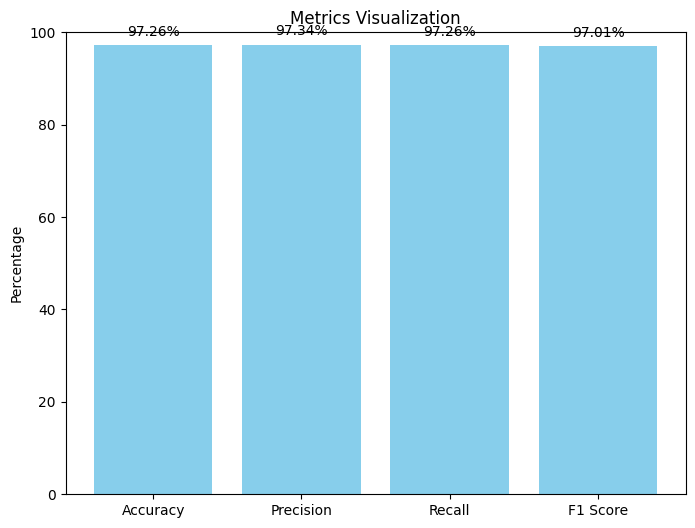

Calculating Confusion Matrix...


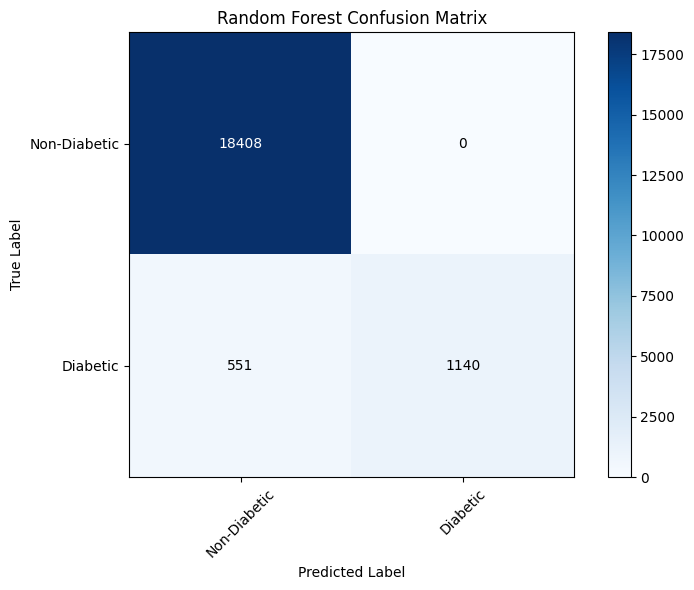

In [160]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Handle null values
def handle_nulls(df, feats, lbl):
    cols = feats + [lbl]  # Combine features and label columns
    i = 0
    while i < len(cols):
        col_name = cols[i]
        if str(df.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            mean_val = df.select(mean(col_name)).collect()[0][0]
            df = df.fillna({col_name: mean_val})
        else:
            df = df.fillna({col_name: "Unknown"})
        i += 1
    return df

# Map categorical columns
def map_cat_cols(df):
    cols = ["gender", "smoking_history"]
    i = 0
    while i < len(cols):
        idx = StringIndexer(inputCol=cols[i], outputCol=f"{cols[i]}_idx").fit(df)
        df = idx.transform(df)
        i += 1
    return df

# Prepare data
def prep_data(df, lbl, feats):
    feats_idx = [f"{col}_idx" if col in ["gender", "smoking_history"] else col for col in feats]
    asm = VectorAssembler(inputCols=feats_idx, outputCol="features")
    df = asm.transform(df)
    df = df.withColumnRenamed(lbl, "label")
    return df

# Plot confusion matrix
def plot_cm(cm, labels, model_name="Model"):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels)

    fmt = "d"
    thr = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(int(cm[i, j]), fmt),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thr else "black",
        )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Main function
def main():
    spark = SparkSession.builder.appName("RF_Metrics").getOrCreate()
    try:
        # Load dataset
        print("Loading dataset...")
        df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)
        print("Dataset Schema:")
        df.printSchema()

        # Define label and features
        lbl = "diabetes"
        feats = ["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]

        # Handle nulls
        print("Handling nulls...")
        df = handle_nulls(df, feats, lbl)

        # Map categorical cols
        print("Mapping categorical columns...")
        df = map_cat_cols(df)

        # Prepare data
        print("Preparing data...")
        df = prep_data(df, lbl, feats)

        # Split data
        train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

        # Train Random Forest
        print("Training Random Forest...")
        rf = RandomForestClassifier(numTrees=10, maxDepth=5, seed=42)
        rf_model = rf.fit(train_df)

        # Evaluate model
        print("Evaluating Random Forest...")
        preds = rf_model.transform(test_df)

        # Metrics calculation
        eval_acc = MulticlassClassificationEvaluator(metricName="accuracy")
        acc = eval_acc.evaluate(preds) * 100
        eval_prec = MulticlassClassificationEvaluator(metricName="weightedPrecision")
        prec = eval_prec.evaluate(preds) * 100
        eval_rec = MulticlassClassificationEvaluator(metricName="weightedRecall")
        rec = eval_rec.evaluate(preds) * 100
        eval_f1 = MulticlassClassificationEvaluator(metricName="f1")
        f1 = eval_f1.evaluate(preds) * 100

        print(f"Accuracy: {acc:.2f}%")
        print(f"Precision: {prec:.2f}%")
        print(f"Recall: {rec:.2f}%")
        print(f"F1 Score: {f1:.2f}%")

        # Visualization for Metrics
        labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
        vals = [acc, prec, rec, f1]

        plt.figure(figsize=(8, 6))
        plt.bar(labels, vals, color='skyblue')
        plt.title("Metrics Visualization")
        plt.ylabel("Percentage")
        plt.ylim(0, 100)
        for i, v in enumerate(vals):
            plt.text(i, v + 2, f"{v:.2f}%", ha='center')
        plt.show()

        # Confusion Matrix
        print("Calculating Confusion Matrix...")
        preds_rdd = preds.select("label", "prediction").rdd.map(lambda row: (row[0], row[1]))
        cm = preds_rdd.toDF(["label", "prediction"]).groupBy("label", "prediction").count().toPandas().pivot(
            index='label', columns='prediction', values='count').fillna(0).to_numpy()
        plot_cm(cm, labels=["Non-Diabetic", "Diabetic"], model_name="Random Forest")

    except Exception as e:
        print(f"Error: {e}")
    finally:
        spark.stop()

if __name__ == "__main__":
    main()


Loading data...
Handling missing data...
Encoding categorical features...
Casting columns...
Preparing RDD...
Training Gradient Boosting...
Evaluating Gradient Boosting...
Gradient Boosting Accuracy: 97.42%
Precision: 100.00%
Recall: 69.21%
F1 Score: 81.80%


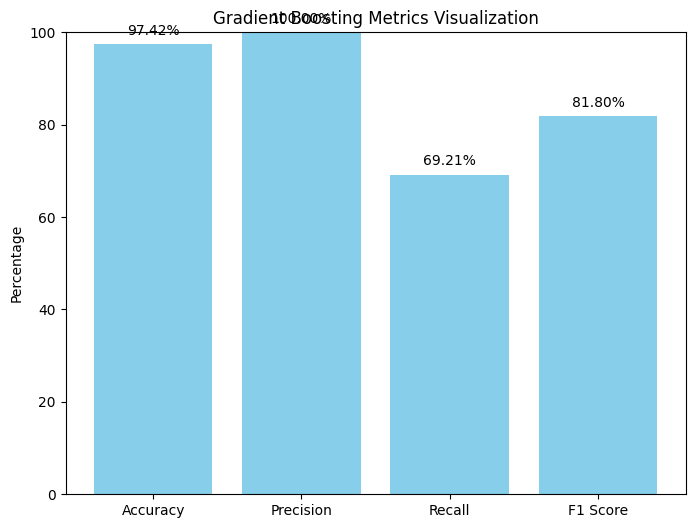

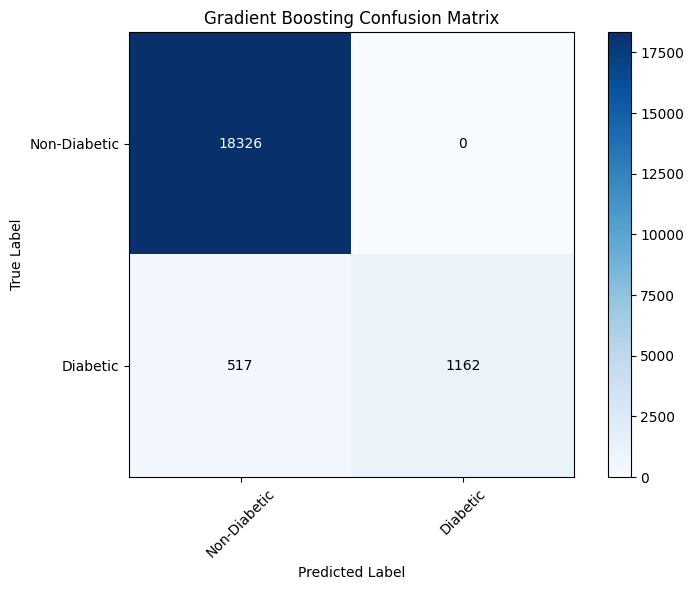

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.tree import GradientBoostedTrees
import matplotlib.pyplot as plt
import numpy as np

# Helper Functions
def cast_columns(data, cols):
    for c in cols:
        data = data.withColumn(c, col(c).cast("double"))
    return data

def fix_nulls(data, features, lbl):
    for col_name in features + [lbl]:
        if str(data.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            avg_val = data.select(mean(col_name)).collect()[0][0]
            data = data.fillna({col_name: avg_val})
        else:
            data = data.fillna({col_name: "Unknown"})
    return data

def encode_categoricals(data, cat_cols):
    for col_name in cat_cols:
        idx_col = f"{col_name}_idx"
        indexer = StringIndexer(inputCol=col_name, outputCol=idx_col).fit(data)
        data = indexer.transform(data)
    return data

def to_labeled_rdd(data, lbl, feats):
    feat_cols = [f"{col}_idx" if col in ["gender", "smoking_history"] else col for col in feats]
    assembler = VectorAssembler(inputCols=feat_cols, outputCol="features", handleInvalid="skip")
    data = assembler.transform(data)
    rdd = data.select("features", lbl).rdd.map(
        lambda row: LabeledPoint(row[lbl], Vectors.dense(row["features"]))
    )
    return rdd

# Gradient Boosting Model
def train_gb_model(train_rdd, test_rdd):
    """
    Train Gradient Boosting Classifier using MLlib.
    """
    try:
        print("Training Gradient Boosting...")
        # Model parameters
        model = GradientBoostedTrees.trainClassifier(
            train_rdd,
            categoricalFeaturesInfo={},
            numIterations=10,  # Number of boosting iterations
            maxDepth=5,  # Depth of trees
        )

        print("Evaluating Gradient Boosting...")
        # Collect predictions on test data
        test_data = test_rdd.collect()  # Collect test data to the driver
        predictions = [(model.predict(point.features), point.label) for point in test_data]
        acc = sum([1 for pred, lbl in predictions if pred == lbl]) / len(predictions) * 100

        # Metrics
        conf_matrix = np.zeros((2, 2))  # Assuming binary classification
        for pred, lbl in predictions:
            conf_matrix[int(lbl)][int(pred)] += 1

        precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]) if conf_matrix[1, 1] + conf_matrix[0, 1] > 0 else 0
        recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if conf_matrix[1, 1] + conf_matrix[1, 0] > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

        return acc, conf_matrix, precision * 100, recall * 100, f1_score * 100
    except Exception as ex:
        print(f"Gradient Boosting Error: {ex}")
        return 0.0, None, 0.0, 0.0, 0.0

def plot_metrics(accuracy, precision, recall, f1_score):
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = [accuracy, precision, recall, f1_score]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_labels, metrics_values, color='skyblue')
    plt.title("Gradient Boosting Metrics Visualization")
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    plt.show()

def plot_confusion_matrix(conf_matrix, labels, model_name="Gradient Boosting"):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = "d"
    thresh = conf_matrix.max() / 2
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(
            j,
            i,
            format(int(conf_matrix[i, j]), fmt),
            ha="center",
            va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
        )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    spark = SparkSession.builder.appName("GradientBoostingClassifier").getOrCreate()
    try:
        print("Loading data...")
        df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)

        # Define features and label
        lbl = "diabetes"
        feats = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]

        # Preprocessing
        print("Handling missing data...")
        df = fix_nulls(df, feats, lbl)

        print("Encoding categorical features...")
        df = encode_categoricals(df, ["gender", "smoking_history"])

        print("Casting columns...")
        df = cast_columns(df, feats + [lbl])

        print("Preparing RDD...")
        rdd = to_labeled_rdd(df, lbl, feats)
        train_rdd, test_rdd = rdd.randomSplit([0.8, 0.2], seed=42)

        # Train and evaluate Gradient Boosting model
        gb_acc, conf_matrix, precision, recall, f1_score = train_gb_model(train_rdd, test_rdd)
        print(f"Gradient Boosting Accuracy: {gb_acc:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall: {recall:.2f}%")
        print(f"F1 Score: {f1_score:.2f}%")

        # Visualizations
        plot_metrics(gb_acc, precision, recall, f1_score)
        plot_confusion_matrix(conf_matrix, ["Non-Diabetic", "Diabetic"])
    except Exception as ex:
        print(f"Error: {ex}")
    finally:
        spark.stop()

if __name__ == "__main__":
    main()


Loading data...
Handling missing data...
Preparing data...
Training Decision Tree...
Decision Tree Accuracy: 97.26%
Precision: 97.26%
Recall: 97.26%
F1 Score: 97.26%


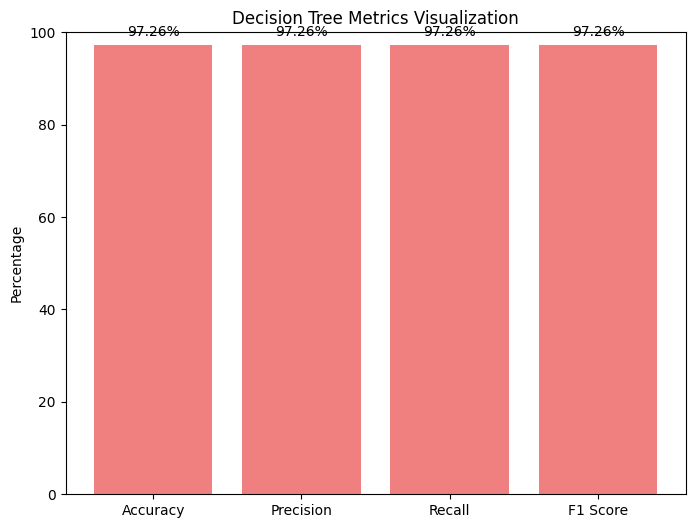

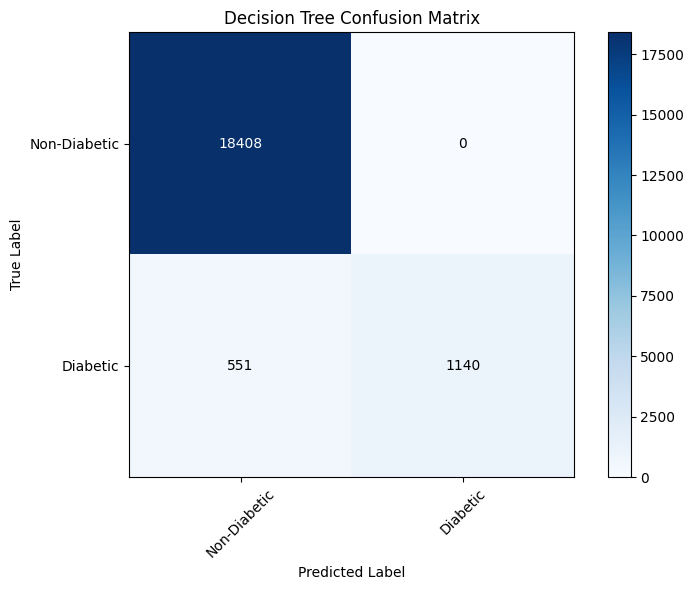

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

def handle_nulls(df, feature_cols, label_col):
    for col_name in feature_cols + [label_col]:
        if str(df.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            mean_value = df.select(mean(col_name)).collect()[0][0]
            df = df.fillna({col_name: mean_value})
        else:
            df = df.fillna({col_name: "Unknown"})
    return df

def prepare_data(df, feature_cols, label_col):
    for col_name in ["gender", "smoking_history"]:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
        df = indexer.fit(df).transform(df)

    indexed_feature_cols = [
        f"{col}_indexed" if col in ["gender", "smoking_history"] else col
        for col in feature_cols
    ]
    assembler = VectorAssembler(inputCols=indexed_feature_cols, outputCol="features")
    df = assembler.transform(df)

    label_indexer = StringIndexer(inputCol=label_col, outputCol="label")
    df = label_indexer.fit(df).transform(df)
    return df

def train_decision_tree(train_data, test_data):
    try:
        dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)
        model = dt.fit(train_data)

        predictions = model.transform(test_data)

        evaluator = MulticlassClassificationEvaluator(
            labelCol="label", predictionCol="prediction", metricName="accuracy"
        )
        accuracy = evaluator.evaluate(predictions) * 100

        # Extract confusion matrix and other metrics
        prediction_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))
        labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()
        conf_matrix = np.zeros((len(labels), len(labels)))

        for pred, label in prediction_and_labels.collect():
            conf_matrix[int(label)][int(pred)] += 1

        precision = np.diag(conf_matrix).sum() / conf_matrix.sum()
        recall = np.diag(conf_matrix).sum() / len(test_data.collect())
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return accuracy, conf_matrix, precision * 100, recall * 100, f1_score * 100
    except Exception as e:
        print(f"Error in Decision Tree training: {e}")
        return 0.0, None, 0.0, 0.0, 0.0

def plot_metrics(accuracy, precision, recall, f1_score):
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = [accuracy, precision, recall, f1_score]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_labels, metrics_values, color='lightcoral')
    plt.title("Decision Tree Metrics Visualization")
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    plt.show()

def plot_confusion_matrix(conf_matrix, labels, model_name="Decision Tree"):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = "d"
    thresh = conf_matrix.max() / 2
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(
            j,
            i,
            format(int(conf_matrix[i, j]), fmt),
            ha="center",
            va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
        )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

def main():
    spark = SparkSession.builder.appName("Decision Tree with Visualizations").getOrCreate()
    try:
        print("Loading data...")
        df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)

        label_col = "diabetes"
        feature_cols = [
            "gender", "age", "hypertension", "heart_disease",
            "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
        ]

        print("Handling missing data...")
        df = handle_nulls(df, feature_cols, label_col)

        print("Preparing data...")
        df = prepare_data(df, feature_cols, label_col)

        train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

        print("Training Decision Tree...")
        accuracy, conf_matrix, precision, recall, f1_score = train_decision_tree(train_data, test_data)
        print(f"Decision Tree Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall: {recall:.2f}%")
        print(f"F1 Score: {f1_score:.2f}%")

        plot_metrics(accuracy, precision, recall, f1_score)
        plot_confusion_matrix(conf_matrix, ["Non-Diabetic", "Diabetic"])
    except Exception as e:
        print(f"Error: {e}")
    finally:
        spark.stop()

if __name__ == "__main__":
    main()


Loading data...
Handling missing data...
Preparing data...
Training Multilayer Perceptron...
Multilayer Perceptron Accuracy: 91.59%
Precision: 91.59%
Recall: 91.59%
F1 Score: 91.59%


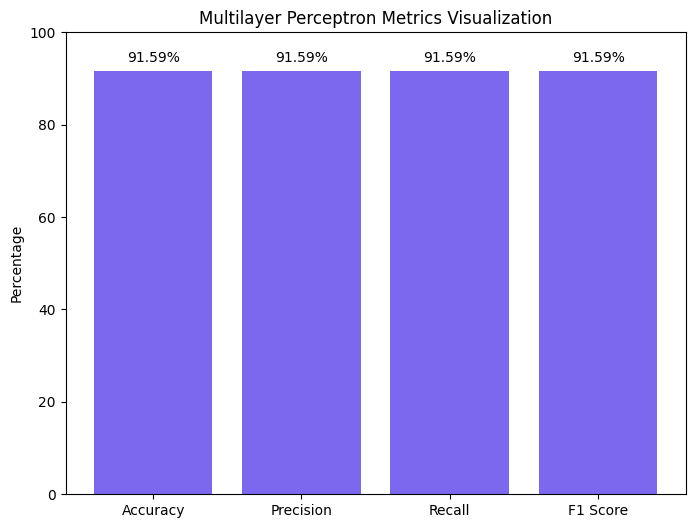

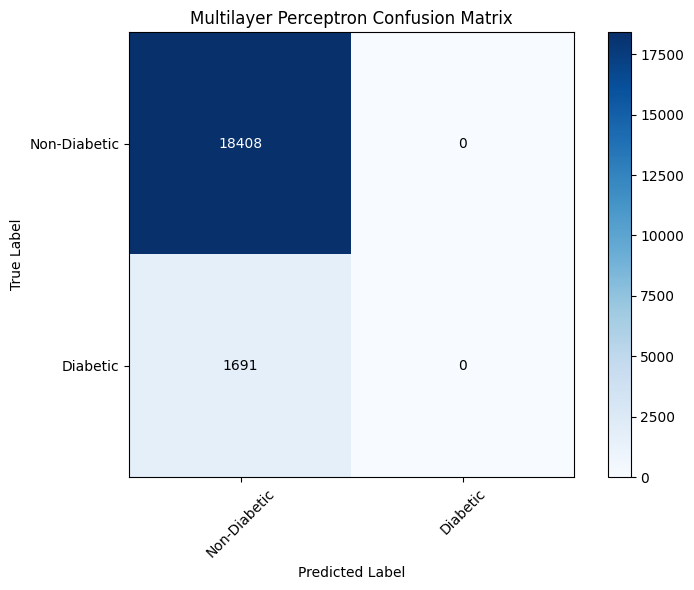

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

# Define preprocessing functions
def handle_nulls(df, feature_cols, label_col):
    for col_name in feature_cols + [label_col]:
        if str(df.schema[col_name].dataType) in ["DoubleType", "IntegerType"]:
            mean_value = df.select(mean(col_name)).collect()[0][0]
            df = df.fillna({col_name: mean_value})
        else:
            df = df.fillna({col_name: "Unknown"})
    return df

def prepare_data(df, feature_cols, label_col):
    for col_name in ["gender", "smoking_history"]:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
        df = indexer.fit(df).transform(df)

    indexed_feature_cols = [
        f"{col}_indexed" if col in ["gender", "smoking_history"] else col
        for col in feature_cols
    ]
    assembler = VectorAssembler(inputCols=indexed_feature_cols, outputCol="features")
    df = assembler.transform(df)

    label_indexer = StringIndexer(inputCol=label_col, outputCol="label")
    df = label_indexer.fit(df).transform(df)
    return df

# Train and Evaluate Multilayer Perceptron Classifier
def train_mlp(train_data, test_data, layers):
    try:
        mlp = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=layers, maxIter=100)
        model = mlp.fit(train_data)
        predictions = model.transform(test_data)

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions) * 100

        # Extract Confusion Matrix and other metrics
        prediction_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))
        labels = predictions.select("label").distinct().rdd.flatMap(lambda x: x).collect()
        conf_matrix = np.zeros((len(labels), len(labels)))

        for pred, label in prediction_and_labels.collect():
            conf_matrix[int(label)][int(pred)] += 1

        precision = np.diag(conf_matrix).sum() / conf_matrix.sum()
        recall = np.diag(conf_matrix).sum() / len(test_data.collect())
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        return accuracy, conf_matrix, precision * 100, recall * 100, f1_score * 100
    except Exception as e:
        print(f"Error in MLP training: {e}")
        return 0.0, None, 0.0, 0.0, 0.0

def plot_metrics(accuracy, precision, recall, f1_score):
    metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score"]
    metrics_values = [accuracy, precision, recall, f1_score]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics_labels, metrics_values, color='mediumslateblue')
    plt.title("Multilayer Perceptron Metrics Visualization")
    plt.ylabel("Percentage")
    plt.ylim(0, 100)
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 2, f"{v:.2f}%", ha='center')
    plt.show()

def plot_confusion_matrix(conf_matrix, labels, model_name="Multilayer Perceptron"):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = "d"
    thresh = conf_matrix.max() / 2
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(
            j,
            i,
            format(int(conf_matrix[i, j]), fmt),
            ha="center",
            va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
        )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    spark = SparkSession.builder.appName("MLP Classifier with Visualizations").getOrCreate()
    try:
        print("Loading data...")
        df = spark.read.csv("/content/diabetes_prediction_dataset.csv", header=True, inferSchema=True)

        label_col = "diabetes"
        feature_cols = [
            "gender", "age", "hypertension", "heart_disease",
            "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
        ]

        print("Handling missing data...")
        df = handle_nulls(df, feature_cols, label_col)

        print("Preparing data...")
        df = prepare_data(df, feature_cols, label_col)

        train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

        print("Training Multilayer Perceptron...")
        layers = [len(feature_cols), 10, 5, 2]  # Input -> Hidden Layers -> Output
        accuracy, conf_matrix, precision, recall, f1_score = train_mlp(train_data, test_data, layers)
        print(f"Multilayer Perceptron Accuracy: {accuracy:.2f}%")
        print(f"Precision: {precision:.2f}%")
        print(f"Recall: {recall:.2f}%")
        print(f"F1 Score: {f1_score:.2f}%")

        plot_metrics(accuracy, precision, recall, f1_score)
        plot_confusion_matrix(conf_matrix, ["Non-Diabetic", "Diabetic"])
    except Exception as e:
        print(f"Error: {e}")
    finally:
        spark.stop()

if __name__ == "__main__":
    main()


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!curl -s https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz | tar -xz -C /content/
!pip install -q pyngrok


In [ ]:
!pip install pyngrok


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"
os.environ["PATH"] += ":/content/spark-3.5.3-bin-hadoop3/bin:/content/spark-3.5.3-bin-hadoop3/sbin"


In [ ]:
from pyngrok import ngrok
from pyspark.sql import SparkSession

# Create Spark session with event logging
spark = SparkSession.builder \
    .appName("DAG Visualization with LR Bayes") \
    .config("spark.eventLog.enabled", "true") \
    .config("spark.eventLog.dir", "/content/spark-events") \
    .getOrCreate()

# Start ngrok to expose Spark History Server
ngrok_tunnel = ngrok.connect(18080)
print(f"Access the Spark History Server at: {ngrok_tunnel.public_url}")


Access the Spark History Server at: https://95e4-34-83-55-63.ngrok-free.app


In [ ]:
!mkdir -p /content/spark-events
!/content/spark-3.5.3-bin-hadoop3/sbin/start-history-server.sh


starting org.apache.spark.deploy.history.HistoryServer, logging to /content/spark-3.5.3-bin-hadoop3/logs/spark--org.apache.spark.deploy.history.HistoryServer-1-a636ce7e09d0.out


In [ ]:
!/content/spark-3.5.3-bin-hadoop3/sbin/stop-history-server.sh
ngrok.disconnect(ngrok_tunnel.public_url)


no org.apache.spark.deploy.history.HistoryServer to stop


Explanation and Analysis [10 marks]: Utilize Spark’s DAG visualizations to explain
the distributed stages of your data preprocessing and machine learning models.
Provide a comparative analysis of the performance of your distributed models against
those developed in Phase 2, focusing on metrics such as execution time, accuracy,
precision and F1 Score. Discuss the effectiveness and advantages of using PySpark
for distributed processing on large datasets, supported by relevant metrics and
visualizations.

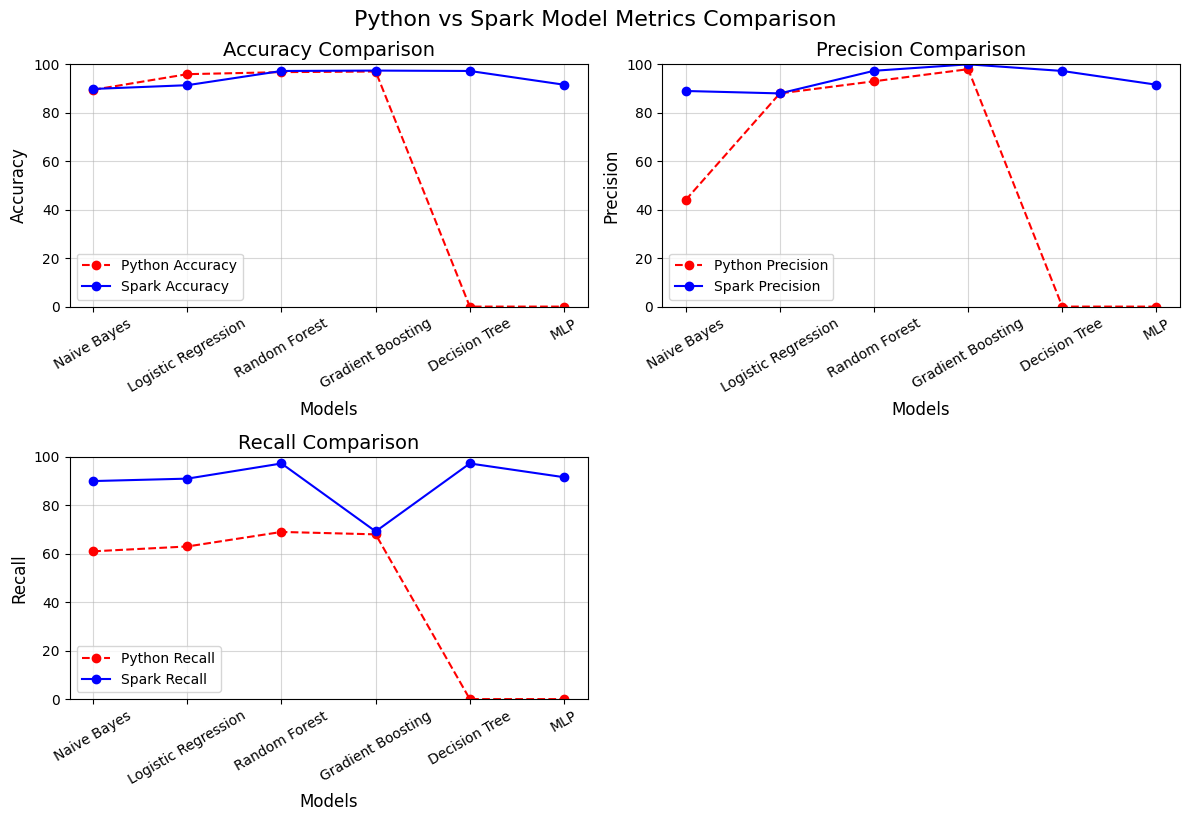

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for models
models = ["Naive Bayes", "Logistic Regression", "Random Forest", "Gradient Boosting", "Decision Tree", "MLP"]

# Python and Spark metrics
python_accuracy = [89.49, 95.94, 96.78, 97.04, 0, 0]
spark_accuracy = [89.84, 91.39, 97.26, 97.42, 97.26, 91.59]

python_precision = [44, 88, 93, 98, 0, 0]
spark_precision = [89, 88, 97.34, 100, 97.26, 91.59]

python_recall = [61, 63, 69, 68, 0, 0]
spark_recall = [90, 91, 97.26, 69.21, 97.26, 91.59]



# Function to plot line graphs
def plot_line_graphs():
    metrics = ["Accuracy", "Precision", "Recall"]
    python_metrics = [python_accuracy, python_precision, python_recall, ]
    spark_metrics = [spark_accuracy, spark_precision, spark_recall]

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        plt.plot(models, python_metrics[i], marker='o', label=f"Python {metric}", linestyle='dashed', color='red')
        plt.plot(models, spark_metrics[i], marker='o', label=f"Spark {metric}", linestyle='solid', color='blue')
        plt.title(f"{metric} Comparison", fontsize=14)
        plt.xlabel("Models", fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.ylim(0, 100)
        plt.xticks(rotation=30, fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(loc="best", fontsize=10)
        plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.suptitle("Python vs Spark Model Metrics Comparison", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot
plot_line_graphs()


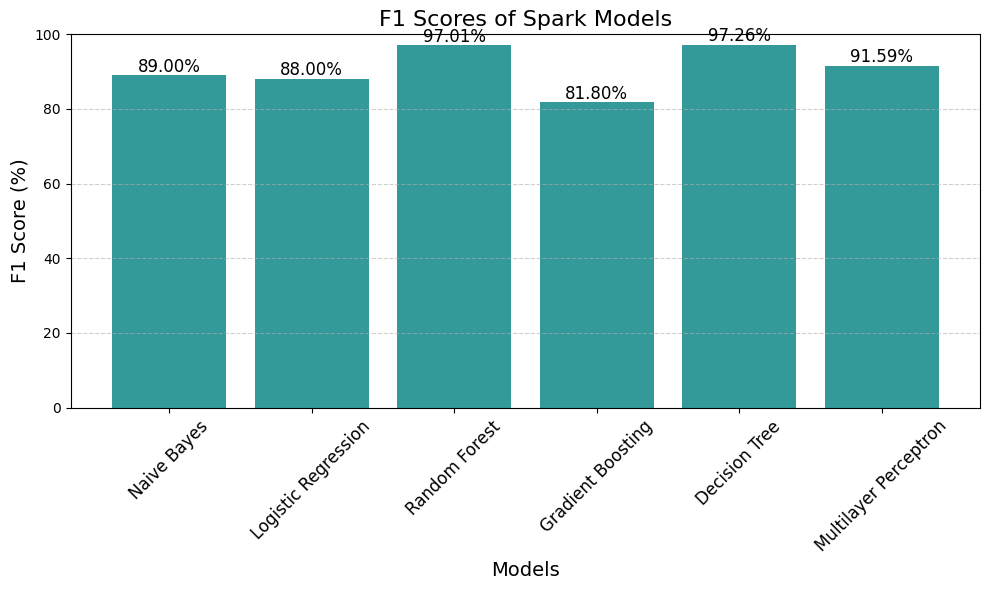

In [137]:
import matplotlib.pyplot as plt

# Data for Spark F1 Scores
models = [
    "Naive Bayes",
    "Logistic Regression",
    "Random Forest",
    "Gradient Boosting",
    "Decision Tree",
    "Multilayer Perceptron",
]
spark_f1_scores = [89, 88, 97.01, 81.8, 97.26, 91.59]

# Create bar graph for F1 Scores
plt.figure(figsize=(10, 6))
plt.bar(models, spark_f1_scores, color='teal', alpha=0.8)
plt.title("F1 Scores of Spark Models", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("F1 Score (%)", fontsize=14)
plt.ylim(0, 100)

# Annotate values on top of bars
for i, score in enumerate(spark_f1_scores):
    plt.text(i, score + 1, f"{score:.2f}%", ha='center', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
